In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image
import numpy as np
import random
from scipy.stats import mode
from collections import Counter

# https://stackoverflow.com/a/45076236/6655150
from matplotlib.colors import ListedColormap 
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

import warnings
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

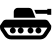

In [3]:
img = Image.open("tank_logo.png")
img

In [4]:
im = np.array(img)

im_blue = im.copy()
im_blue[:,:,2] += 140

im_red = im.copy()
im_red[:,:,0] += 140

In [5]:
distance = lambda p1, p2: np.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2) 

n = 25
scale=2
xx, yy = np.meshgrid(list(range(0,n*scale+1)), list(range(0,n*scale+1)))
xr, yr = xx.ravel(), yy.ravel()

In [10]:
class Game:
    """
        This class should handle the turns. If a move cannot happen in one turn, it should get queued or limited.
    """    
    
    pass


class Turn:
    
    # tank speed, how much they can move per turn
    _speed = 3
    
    def __init__(self, map_):
        self.map = map_
        
    
    def turn(self, instructions):
        """
            orders: a dictionary of orders: {general:[[acquire_tank, {'T': T}],
                                                      [order_tank, dict(**kwargs)],
                                                      [order3...]]}
        """
        for general, orders in instructions.items():
            for order in orders:
                if order[0] == "acquire_tank":
                    general.acquire_tank(**order[1]) # T
                elif order[0] == "order_tank":
                    T = order[1]["T"]
                    nx, ny = order[1]["pos"]

                    # if ordered too far, adjust apropriately
                    if distance((nx,ny), (T.x, T.y)) > Turn._speed:
                        if abs(T.x - nx) > abs(T.y - nx):
                            # more more to the X, but not more than nx/ny
                            nx = min(nx, np.sign(nx - T.x) * 2) + T.x
                            ny = min(ny, np.sign(ny - T.y) * 1) + T.y
                        else:
                            # more more to the Y, but not more than nx/ny
                            nx = min(nx, np.sign(nx - T.x) * 1) + T.x
                            ny = min(ny, np.sign(ny - T.y) * 2) + T.y

                    general.order_tank(T, (nx, ny)) # T, pos
                elif order[0] == "purchase_tanks":
                    general.purchase_tanks(**order[1]) # any of the valid kwargs
                else:
                    print("Command not recognized.")
                    
        self.resolve_battles()
        
        return m.plot()
        

    def resolve_battles(self):
        """Perform any fighting left before closing the turn"""
        for row in self.map.map:
            for p in row:
                # while no country has occupied the patch, 
                # kill tanks at random, based on each country's strength
                while len(set([tt.country for tt in p.residents]))>1:
                    patch_counter = Counter(p.residents)
                    tank_to_kill = random.choices(list(patch_counter.keys()),
                                                  weights=list(patch_counter.values()))[0]
                    if tank_to_kill.general is not None:
                        tank_to_kill.general.tanks.remove(tank_to_kill)
                        tank_to_kill.general = None
                    tank_to_kill.map.tanks.remove(tank_to_kill)
                    tank_to_kill.map = None
                    p.remove(tank_to_kill)
                    tank_to_kill.patch = None
                    tank_to_kill._move(None, None)

                    print(f"Tank '{tank_to_kill.name}' from: '{tank_to_kill.country}' got destroyed!")

                    
        

class General:
    
    def __init__(self, name, country, map_, pos=(0,0), tanks=None):
        self.name = name
        self.country = country
        if tanks is not None:
            self.tanks = tanks
        else:
            self.tanks = []
            
        self.map = map_
        self.map.generals.append(self)
        self.x, self.y = pos
        
        
    ### Available commands (to be used by Turn) ###    
    
    def acquire_tank(self, T):
        # mainly used to get tanks from other generals / tansfer ownership
        self.tanks.append(T)
        if (T.general is not None) and (len(T.general.tanks)>0): 
            T.general.tanks.remove(T)
        T.general = self
        
    def purchase_tanks(self, n=5, *, type_="StuG", types=None):
        if types is None:
            for _ in range(n):
                new_tank = Tank(type_, self.country)
                new_tank.general = self
                self.tanks.append(new_tank) # add tank to general's army
                self.map.add_tank(new_tank, x=self.x, y=self.y) # add tank to map
        else:
            if isinstance(types, (list, tuple)) and len(types)==n:
                for t in types:
                    new_tank = Tank(t, self.country)
                    new_tank.general = self
                    self.tanks.append(new_tank) # add tank to general's army
                    self.map.add_tank(new_tank, x=self.x, y=self.y) # add tank to map
            else:
                print("Error with purchasing tanks.")
                
    def order_tank(self, T, pos):
        assert(T in self.tanks)
        x,y = pos
        T.move(x, y)
            
            
class Country:
    
    def __init__(self, color="red"):
        self.color = color
        self.tanks = []
    
    def add_tank(self, T):
        self.tanks.append(T)
        
    def __str__(self):
        return self.color.upper()
        

class Tank:
    
    def __init__(self, name, country):
        """
            name: name of the tank (doesn't really matter)
            country: pick a color for plotting options
        """
        
        # initialize tank
        self.name = name
        self.country = country
        self.x = None
        self.y = None
        self.patch = None
        self.map = None
        self.general = None
        
        # finally, add tanky to Country's army
        country.add_tank(self)
        
    def __str__(self):
        return f"Tank {self.name}, ({self.x},{self.y})"
    
    def _move(self, x, y):
        self.x = x
        self.y = y
        
    def move(self, x, y):
        self._move(x,y)
        if self.patch is not None:
            self.patch.remove(self) # remove self from old patch
        self.patch = self.map.map[y-1][x-1] # change reference patch
        self.patch.append(self) # add self to that patch
        
    
    
class Patch:
    
    def __init__(self, y, x, map_):
        self.x = x
        self.y = y
        self.residents = []
        self.map = map_
        self.color = "white"
        
    def __str__(self):
        return f"Patch ({self.x}, {self.y}), [{len(self.residents)}]"
    
    def append(self, T):
        self.residents.append(T) # add tank to patch
        
        T._move(self.x, self.y)
        T.patch = self
        T.map = self.map
        
    def remove(self, T):
        self.residents.remove(T)
    
    
class Map:
    
    def __init__(self, size=9):
        self.size = size
        self.map = [[Patch(x, y, self) for y in range(1, size+1)] for x in range(1,size+1)]
        self.tanks = []
        self.generals = []
        self.map_score = 0
    
    def __str__(self):
        s = ""
        for row in self.map:
            for col in row:
                s += f"{col}\t"
            s += "\n"
        
        return s
    
    def add_tank(self, T, x=1, y=1):
        self.map[y-1][x-1].append(T) # this appends a tank to a patch of the map
        self.tanks.append(T) # adds the tank to the map's list of tanks
            
    def to_array(self):
        return np.array([[len(patch.residents) for patch in row] for row in self.map])

    def plot(self, *, k=3, scale=2):
        fig, ax = plt.subplots(figsize=(16,11)) 
    
        # plot tanks
        for tank in self.tanks:
            if tank.country.color == "blue":
                tank_im = im_blue
            else:
                tank_im = im_red
                
            ax.imshow(tank_im, aspect='auto',
                          extent=(tank.x*scale+0.5, tank.x*scale-0.5, tank.y*scale-0.5, tank.y*scale+0.5),
                          zorder=2)
            attack_range = plt.Circle((tank.x*scale, tank.y*scale), 2,
                                      color=tank.country.color, fill=False)
            ax.add_artist(attack_range)
            
            line_of_sight = plt.Circle((tank.x*scale, tank.y*scale), 4,
                                       color=tank.country.color, fill=False, alpha=0.5)
            ax.add_artist(line_of_sight)

        for row in self.map:
            for p in row:
                if len(p.residents)>=1:
                    ax.text(p.x*scale+0.3, p.y*scale+0.3, f'{len(p.residents)}',)

        # plot base map
        ax.imshow(np.zeros((self.size*scale, self.size*scale)), cmap="gray_r")
        
        
        ## Plot area of influence
        if len(self.tanks)>=1:
            coords = np.array([(t.x*scale, t.y*scale) for t in self.tanks])
            countries = np.array([t.country.color for t in self.tanks])

            # K=3 nearest neighbor
            distances = np.array([distance((x,y), (coords[:,0], coords[:,1])).argsort()[:k]
                   for x,y in zip(xr, yr)])
            if len(self.tanks)>2:
                # https://stackoverflow.com/a/6252494/6655150
                col = np.array([mode(countries[d]).mode[0] for d in distances])
            else:
                col = np.array([countries[d][0] for d in distances])
            
            # create an array for the color mesh
            col = np.array([1 if v=="blue" else 0 for v in col])
            col = col.reshape((self.size*scale+1, self.size*scale+1))
            
            self.map_score = 0
            # assign colors to patches
            for yi in range(self.size):
                for xi in range(self.size):
                    self.map[yi][xi].color = "blue" if col[yi][xi] else "red"
                    self.map_score += 2* (col[yi][xi]-0.5) # plus (blue) or minus (red) one

            ax.pcolormesh(xx, yy, col,
                          cmap=cmap_light, vmin=0, vmax=1.)
        
        for i, general in enumerate(self.generals):
            ax.text(self.size*scale+2*scale, self.size*scale-3-i*scale,
                    f"General {general.name}'s tanks: {len(general.tanks)}")
        
        ax.set_xlim(1, self.size*scale)
        ax.set_xticks(np.arange(1, self.size*scale+1, 2))
        ax.set_xticklabels(np.arange(1, self.size*scale+1))
        ax.set_ylim(1, self.size*scale)
        ax.set_yticks(np.arange(1, self.size*scale+1, 2))
        ax.set_yticklabels(np.arange(1, self.size*scale+1))
        
        # handle a grid
        for x in range(self.size):
            ax.axhline(x*scale+0.5*scale, color="k", alpha=0.6)
            ax.axvline(x*scale+0.5*scale, color="k", alpha=0.6)

        return fig

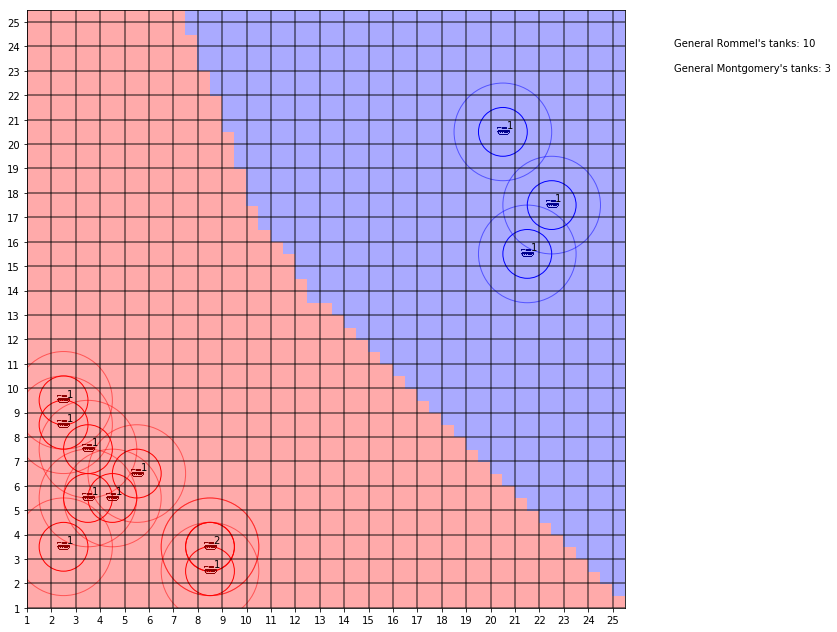

In [11]:
m = Map(n)
t = Turn(m)

red = Country("red")
blue = Country("blue")

Rommel = General("Rommel", red, map_=m, pos=(2,2))
Montgomery = General("Montgomery", blue, map_=m, pos=(20,20))

for _ in range(10):
    tt = Tank("Stug", red)
    m.add_tank(tt, random.randint(2,10), random.randint(2,10))
    Rommel.acquire_tank(tt)

    
for _ in range(3):
    tt = Tank("Panzer", blue)
    m.add_tank(tt, random.randint(15,22), random.randint(15,22))
    Montgomery.acquire_tank(tt)


fig = m.plot()

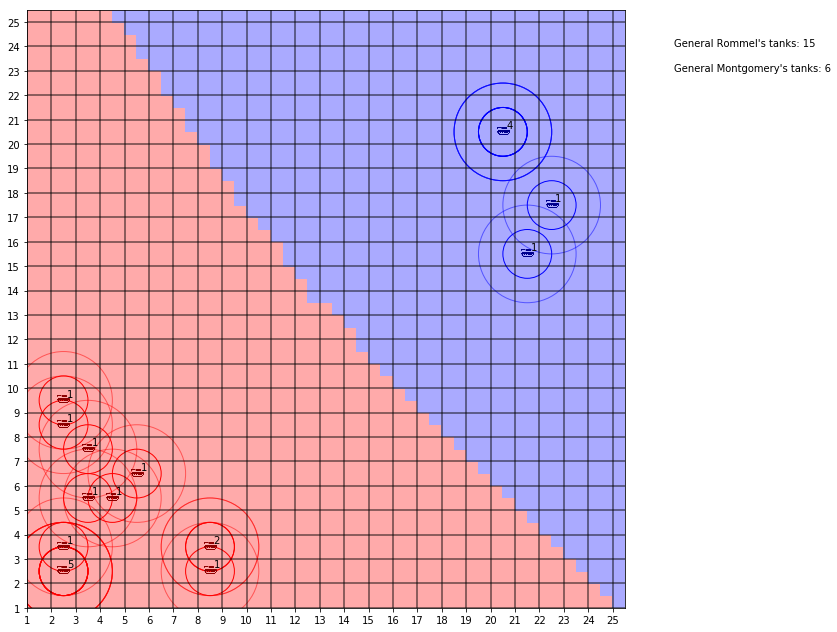

In [12]:
Rommel.purchase_tanks(n=5)
Montgomery.purchase_tanks(n=3)

fig = m.plot()

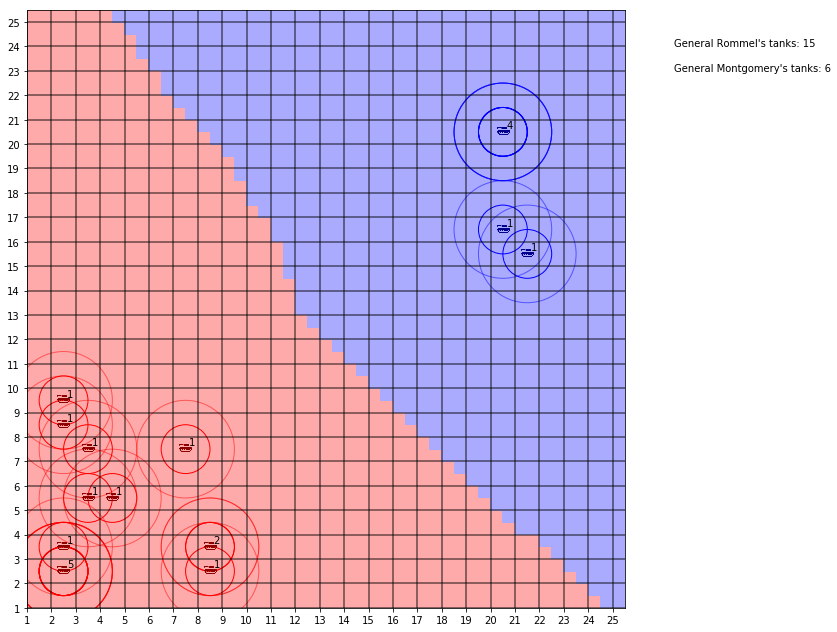

In [13]:
instructions = {
    Rommel: [["order_tank", {'T': Rommel.tanks[0], 'pos': (18,23)}],
                ],
    Montgomery: [["order_tank", {'T': Montgomery.tanks[0], 'pos': (10,10)}],
                ],
    
}

fig = t.turn(instructions=instructions)

In [14]:
# calculate distances from enemy's tanks
def bot_instructions():
    
    ds = [(distance((T.x, T.x), (t.x, t.y)), t) for t in Montgomery.tanks for T in Rommel.tanks]
    closest_enemy_tank = min(ds, key=lambda x: x[0])[1]

    Bot_instructions = {
        Rommel : [["order_tank", {'T': t, 'pos': (closest_enemy_tank.x, closest_enemy_tank.y)}]
                   for t in Rommel.tanks]}
    
    return Bot_instructions

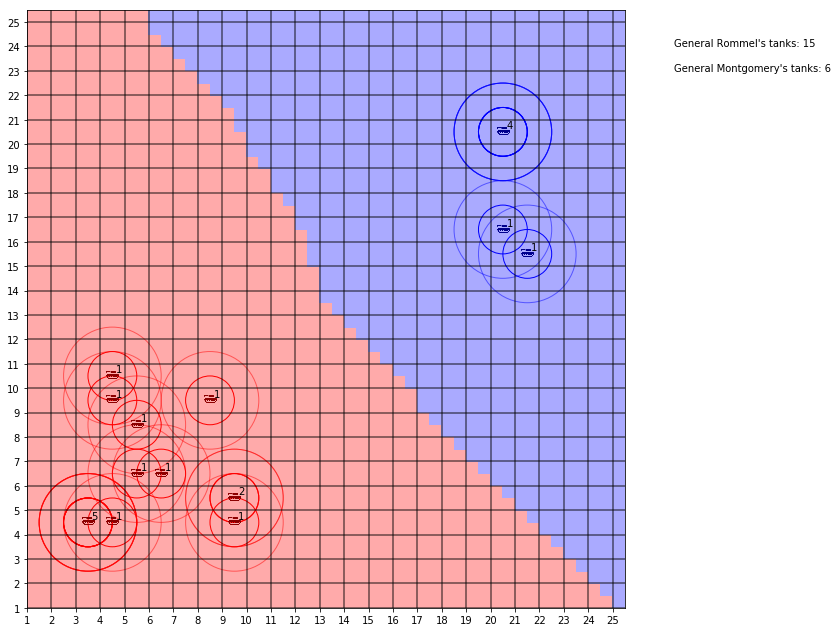

In [15]:
fig = t.turn(bot_instructions())

Tank 'Panzer' from: 'BLUE' got destroyed!
Tank 'Stug' from: 'RED' got destroyed!
Tank 'Stug' from: 'RED' got destroyed!
Tank 'Stug' from: 'RED' got destroyed!
Tank 'Stug' from: 'RED' got destroyed!
Tank 'StuG' from: 'BLUE' got destroyed!
Tank 'Panzer' from: 'BLUE' got destroyed!
Tank 'Stug' from: 'RED' got destroyed!
Tank 'Stug' from: 'RED' got destroyed!
Tank 'StuG' from: 'BLUE' got destroyed!
Tank 'StuG' from: 'BLUE' got destroyed!
Tank 'StuG' from: 'RED' got destroyed!
Tank 'Stug' from: 'RED' got destroyed!
Tank 'StuG' from: 'RED' got destroyed!
Tank 'Stug' from: 'RED' got destroyed!
Tank 'Stug' from: 'RED' got destroyed!
Tank 'StuG' from: 'RED' got destroyed!
Tank 'Stug' from: 'RED' got destroyed!
Tank 'Panzer' from: 'BLUE' got destroyed!


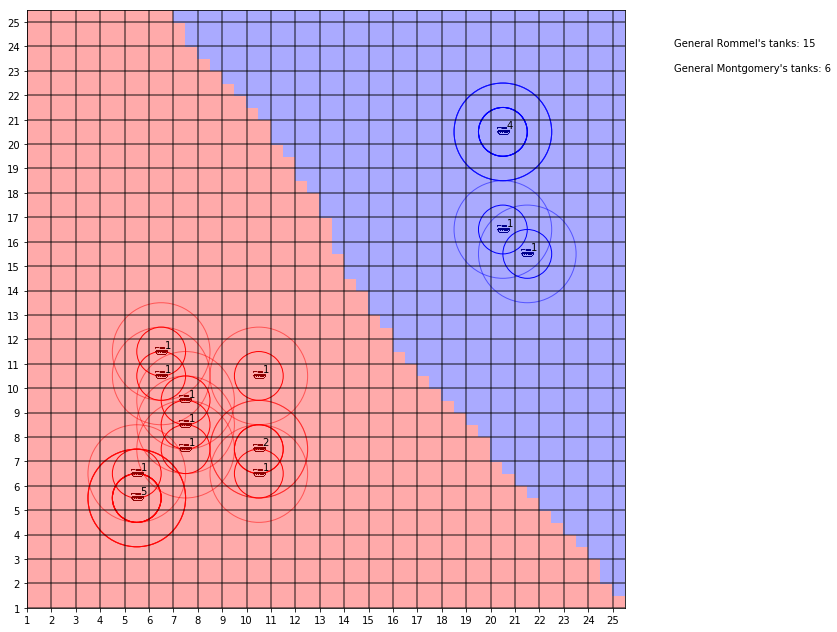

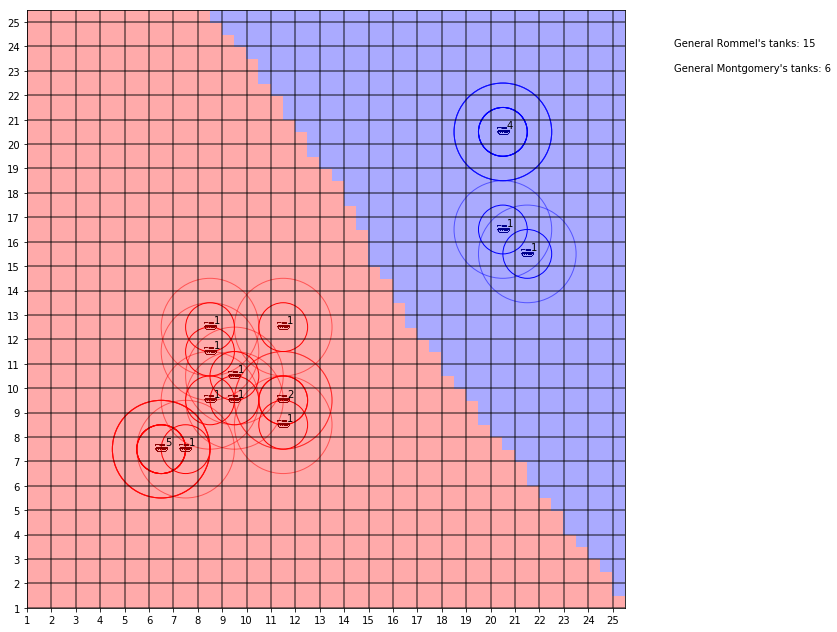

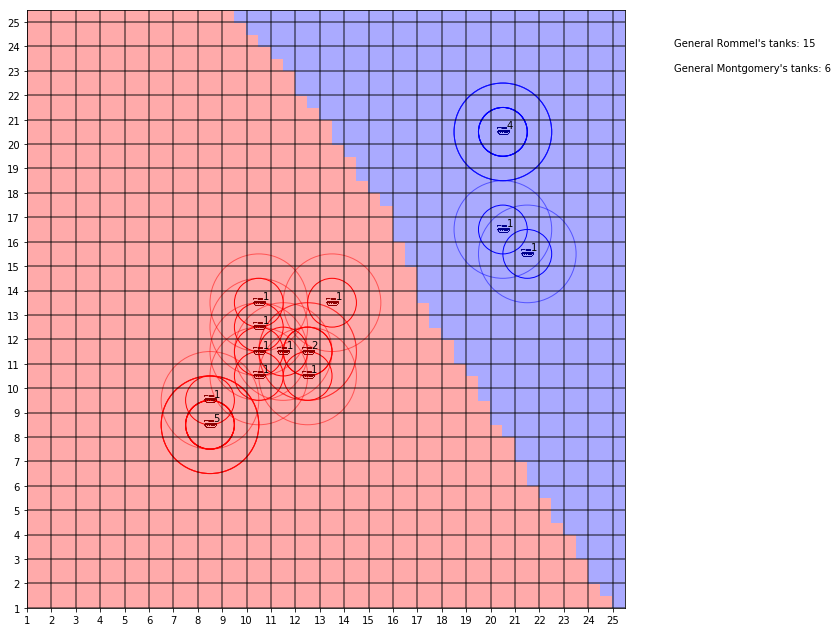

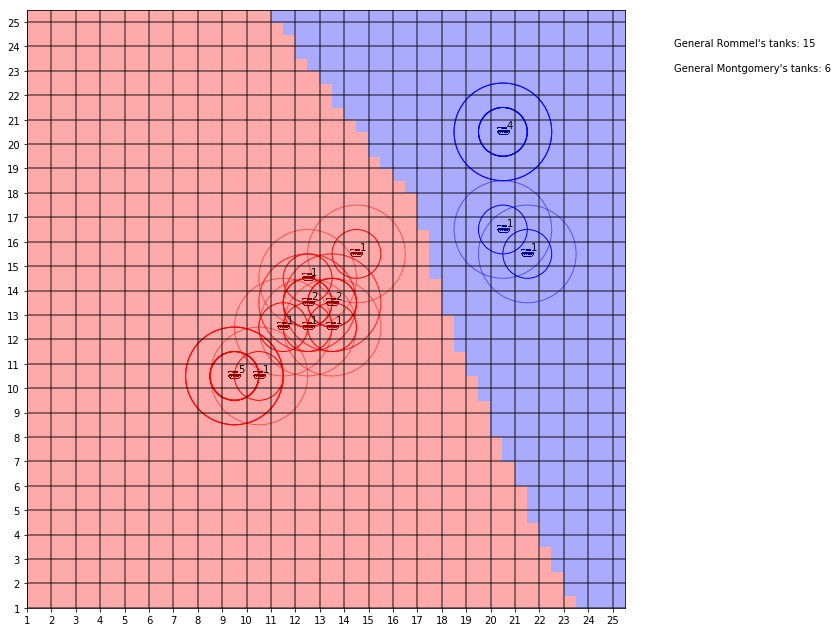

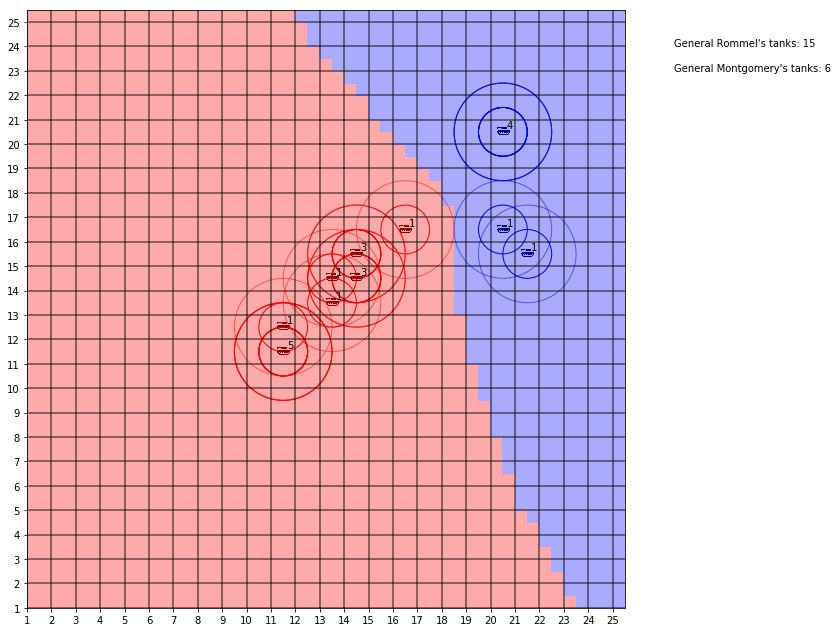

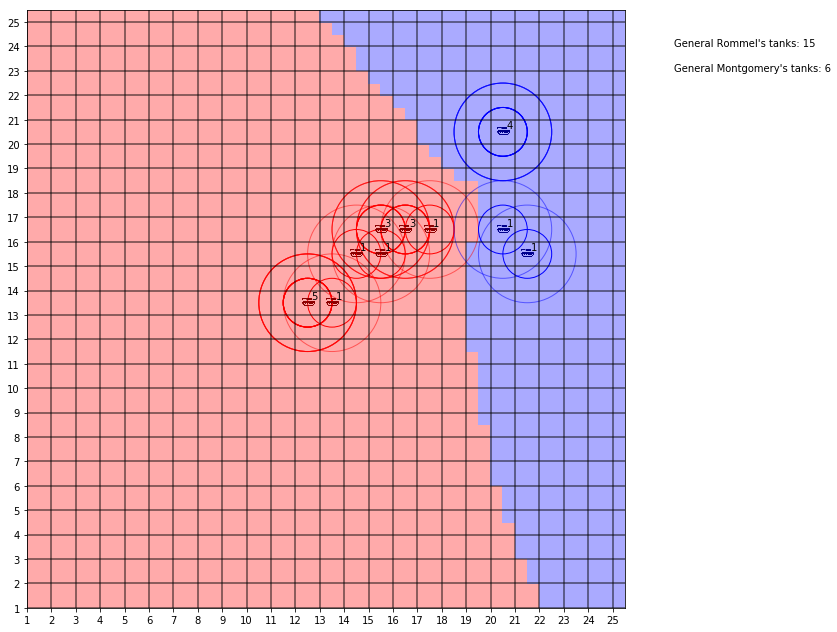

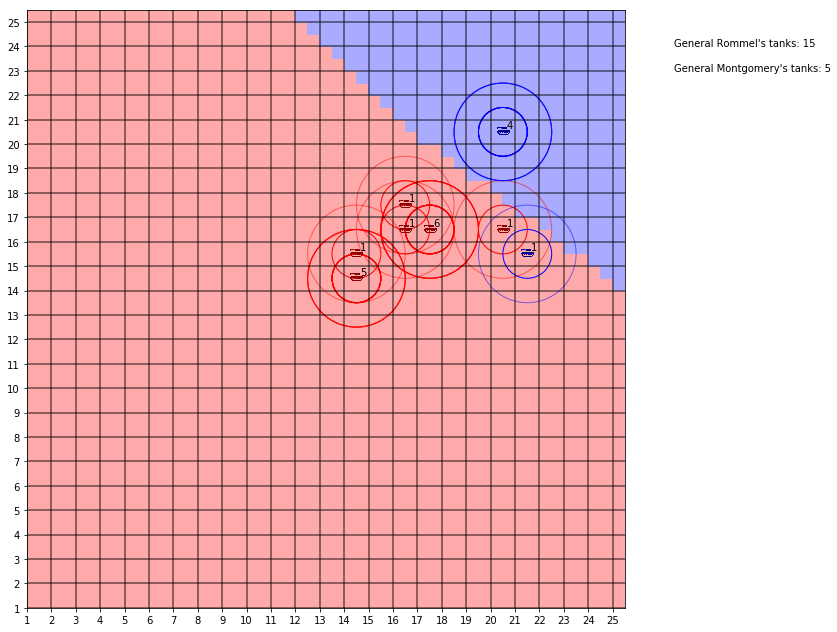

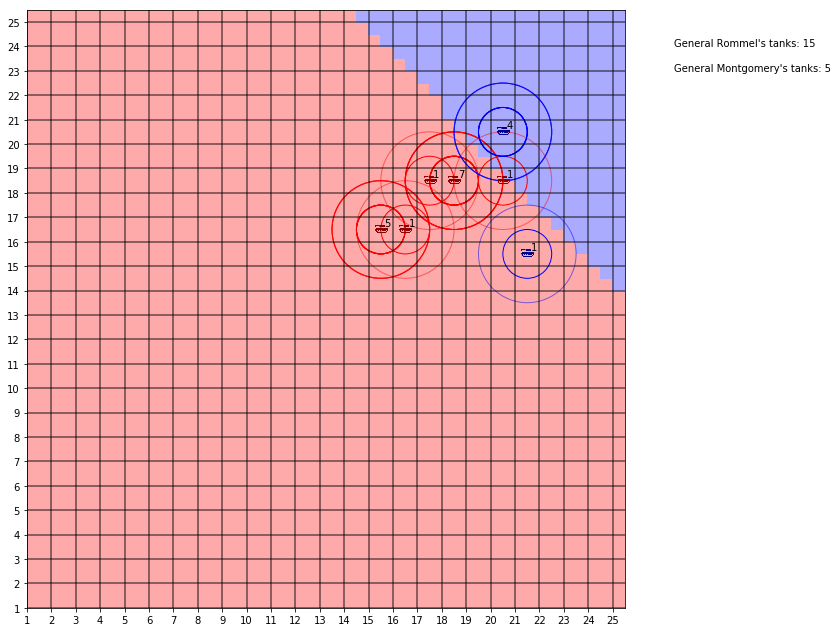

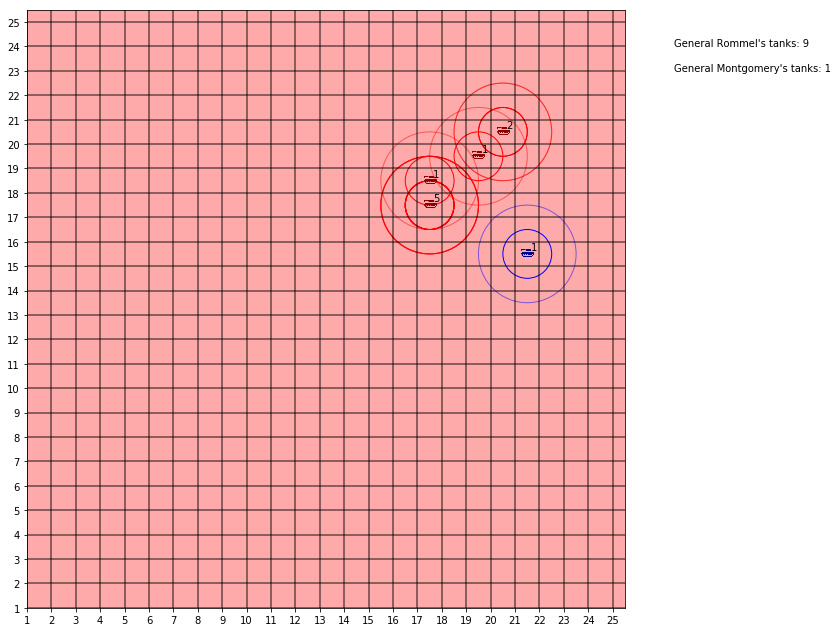

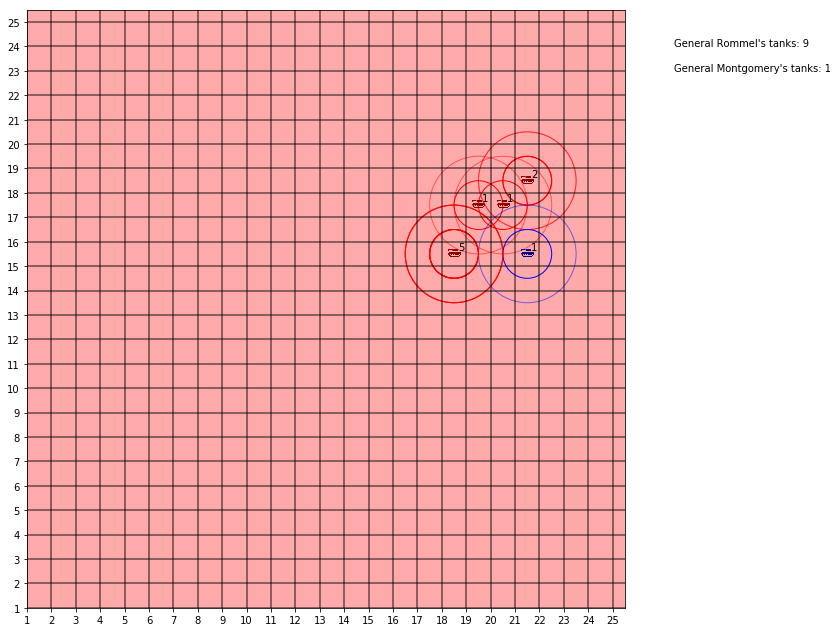

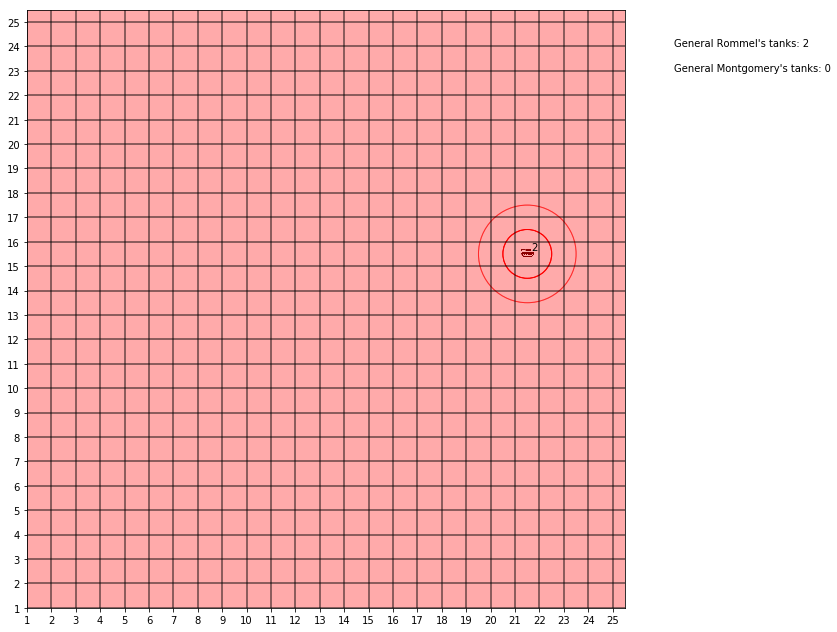

In [16]:
# remove old images
for img in os.listdir("tank_sim"):
    os.remove("tank_sim/"+img)

i = 1
while (Rommel.tanks) and (Montgomery.tanks):
    fig = t.turn(bot_instructions())
    fig.savefig(f"tank_sim/{str(i).zfill(3)}.png")
    i += 1
    
fig.savefig(f"tank_sim/{str(i).zfill(3)}.png")
fig.savefig(f"tank_sim/{str(i+1).zfill(3)}.png");